In [58]:
import warnings
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.sm_exceptions import ValueWarning
from scipy.stats import norm

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.simplefilter("ignore", FutureWarning)  # ignore some seaborn warnings until they update numpy
# silence statsmodels warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", ValueWarning)

In [3]:
df = pandas.read_csv("NHL_API_point_totals_by_team_season_raw_1996-2003.csv")
vegas_df = df[df["team"] == "VGK"].copy()
vegas_df

,team,season_end,total_points,points_rank
673,VGK,2018,109,5
704,VGK,2019,93,15
735,VGK,2020,86,7
766,VGK,2021,82,2
797,VGK,2022,94,17
829,VGK,2023,111,5


In [4]:
vegas_df["season_end"] = vegas_df["season_end"].apply(lambda x : date(month=5, day=1, year=x))
vegas_df["season_end"] = pandas.to_datetime(vegas_df["season_end"])

In [5]:
vegas_df = vegas_df.set_index("season_end")

In [59]:
ar = AutoReg(vegas_df["total_points"][0:-1], lags=1, trend="ct").fit()

In [60]:
ar.forecast(1)

2023-05-01    121.511905
Freq: AS-MAY, dtype: float64

In [61]:
ar = AutoReg(vegas_df["total_points"], lags=1, trend="ct").fit()

In [62]:
ar.forecast(1)

2024-05-01    137.595593
Freq: AS-MAY, dtype: float64

---

In [69]:
def bootstrap(data):
    dist = norm(loc=data.mean(), scale=data.std())
    bootstrap_forecasts = []
    n = 100
    for i in range(0, n):
        combo = dist.rvs(len(data))
        s = pandas.Series(combo, index=data.index)
        ar = AutoReg(s, lags=1, trend="ct").fit()
        bootstrap_forecasts.append(ar.forecast(1).values[0])
    return bootstrap_forecasts

In [70]:
eval_forecasts = bootstrap(vegas_df["total_points"][0:-1])

In [71]:
np.mean(eval_forecasts)

92.35087902393703

In [72]:
np.std(eval_forecasts, ddof=1)

25.168272298991454

In [73]:
np.min(eval_forecasts)

35.3160906078344

In [74]:
np.max(eval_forecasts)

209.82845720538333

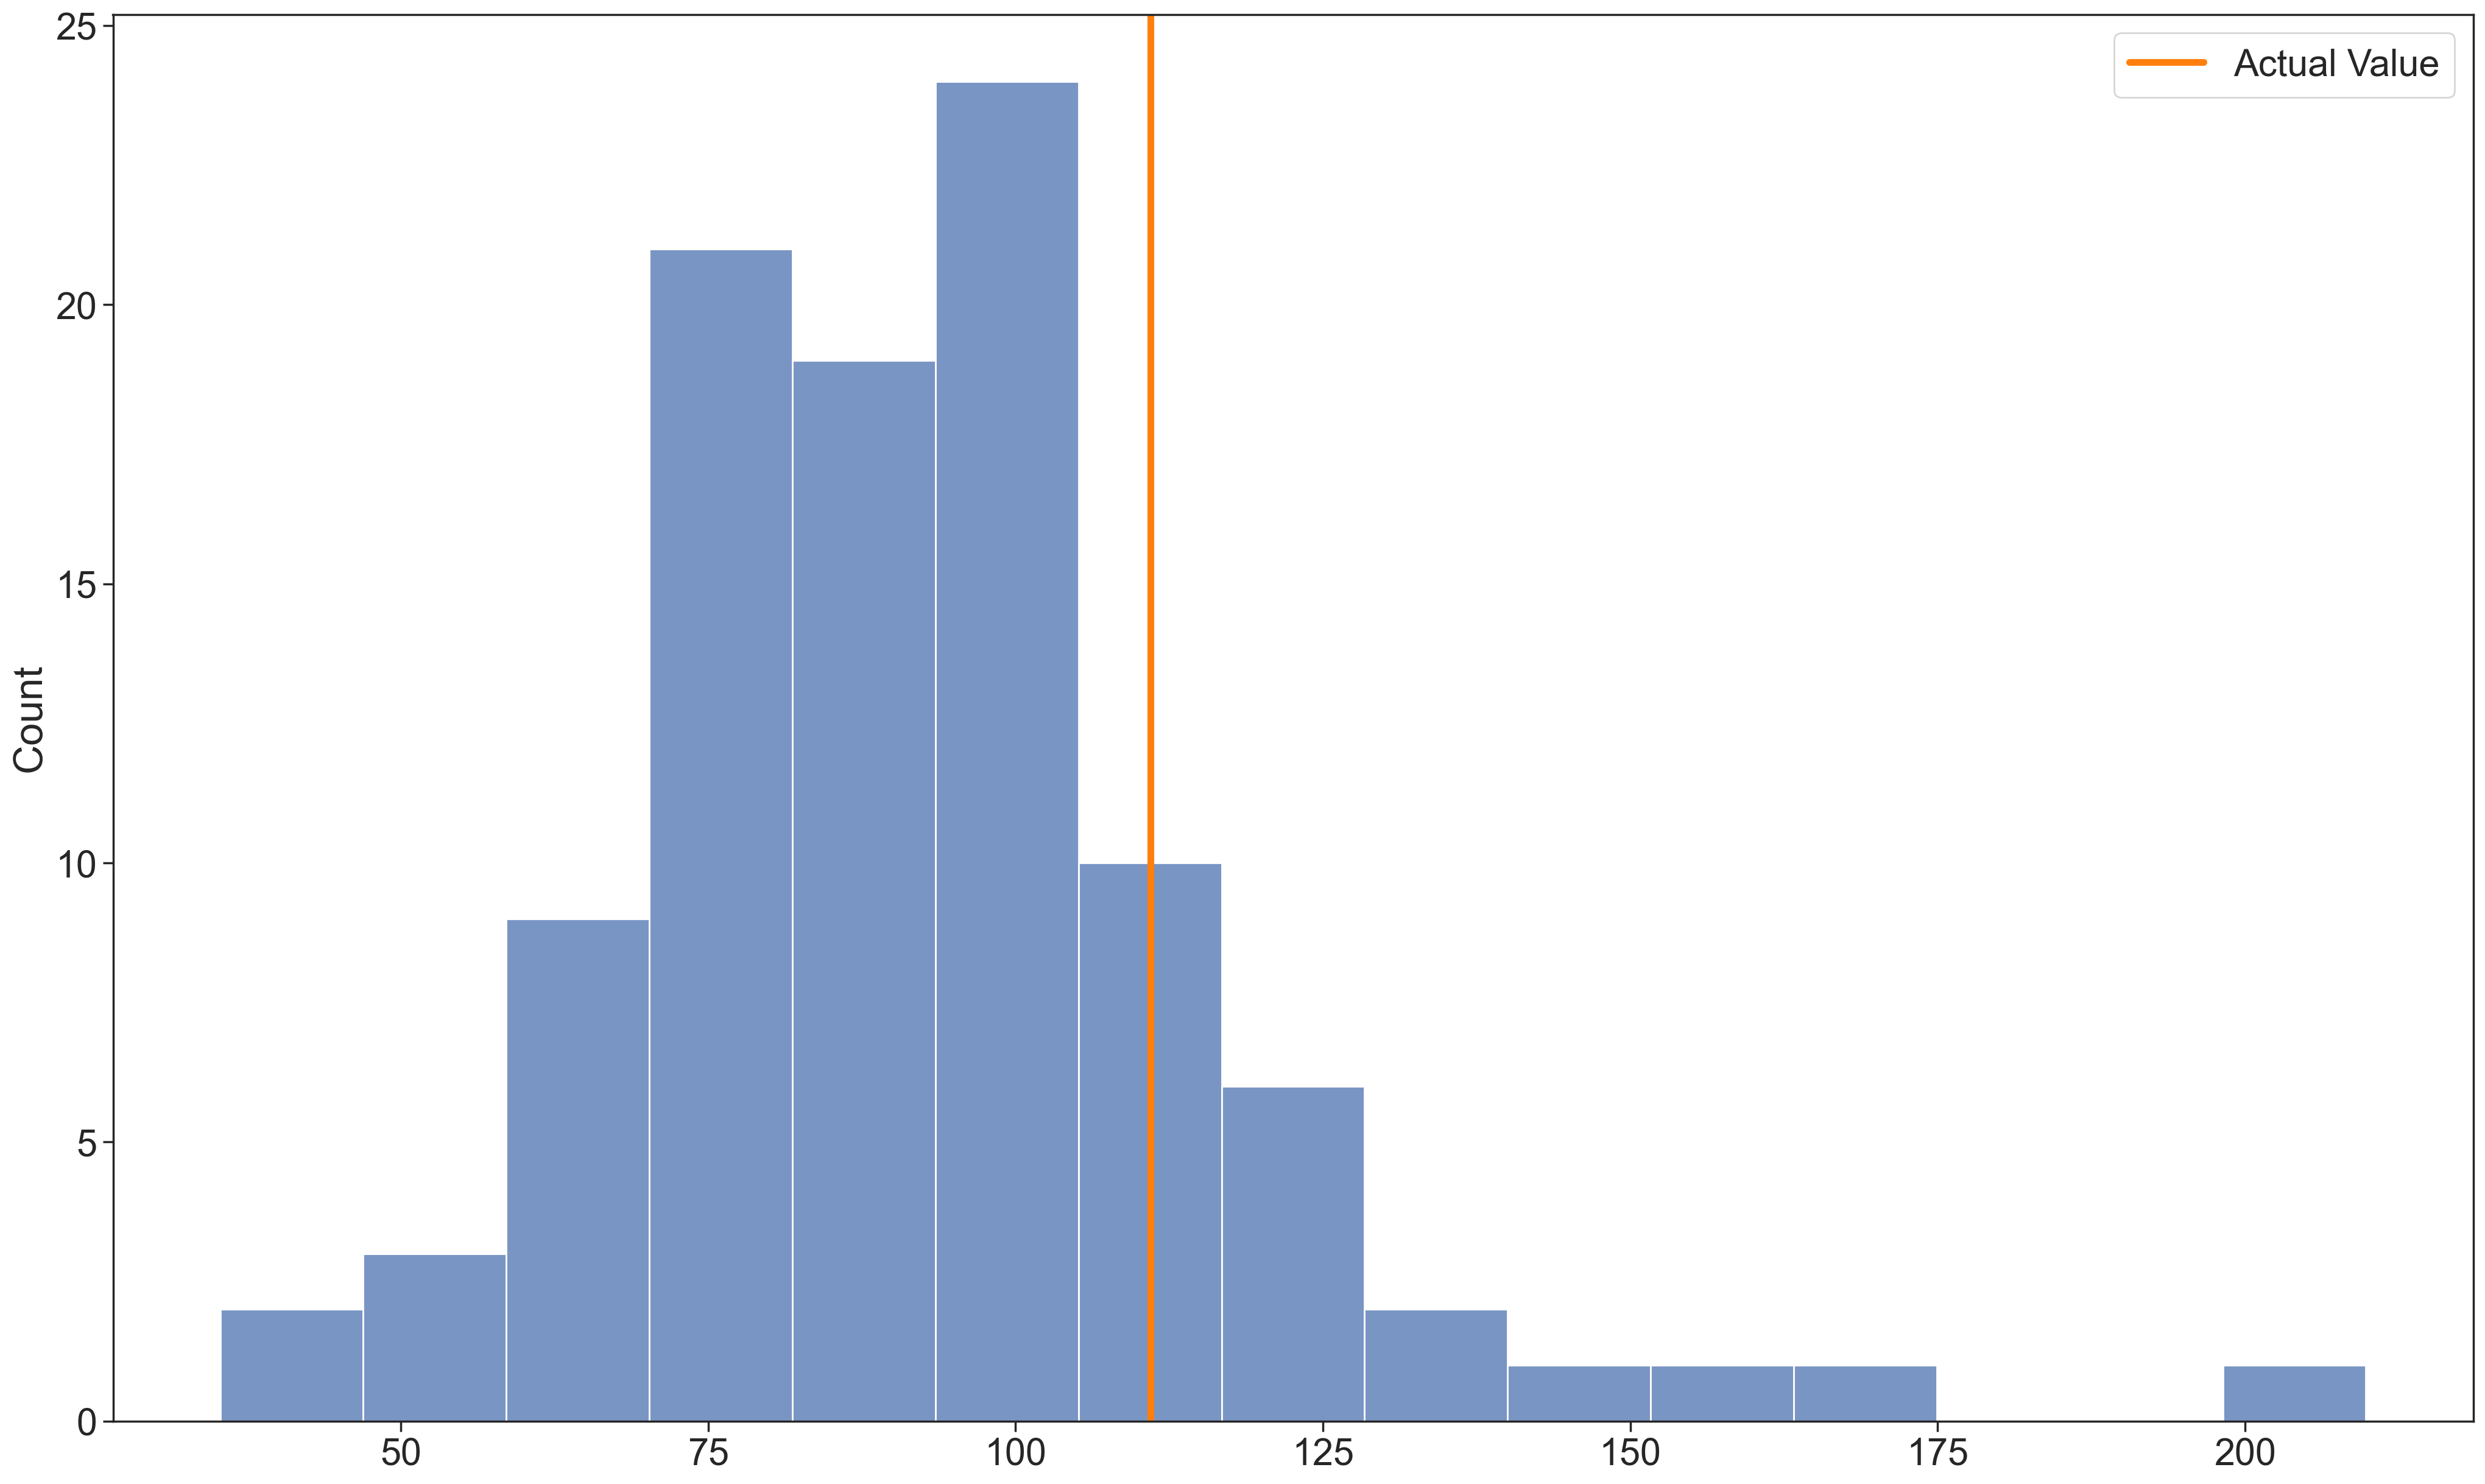

In [75]:
ax = sns.histplot(x=eval_forecasts)
ax.axvline(vegas_df["total_points"][-1], linewidth=4, color="tab:orange", label="Actual Value")
ax.legend()
plt.show()

In [84]:
next_forecasts = bootstrap(vegas_df["total_points"])

In [85]:
np.mean(next_forecasts)

93.80229013945376

In [86]:
np.std(next_forecasts, ddof=1)

18.16018115614626

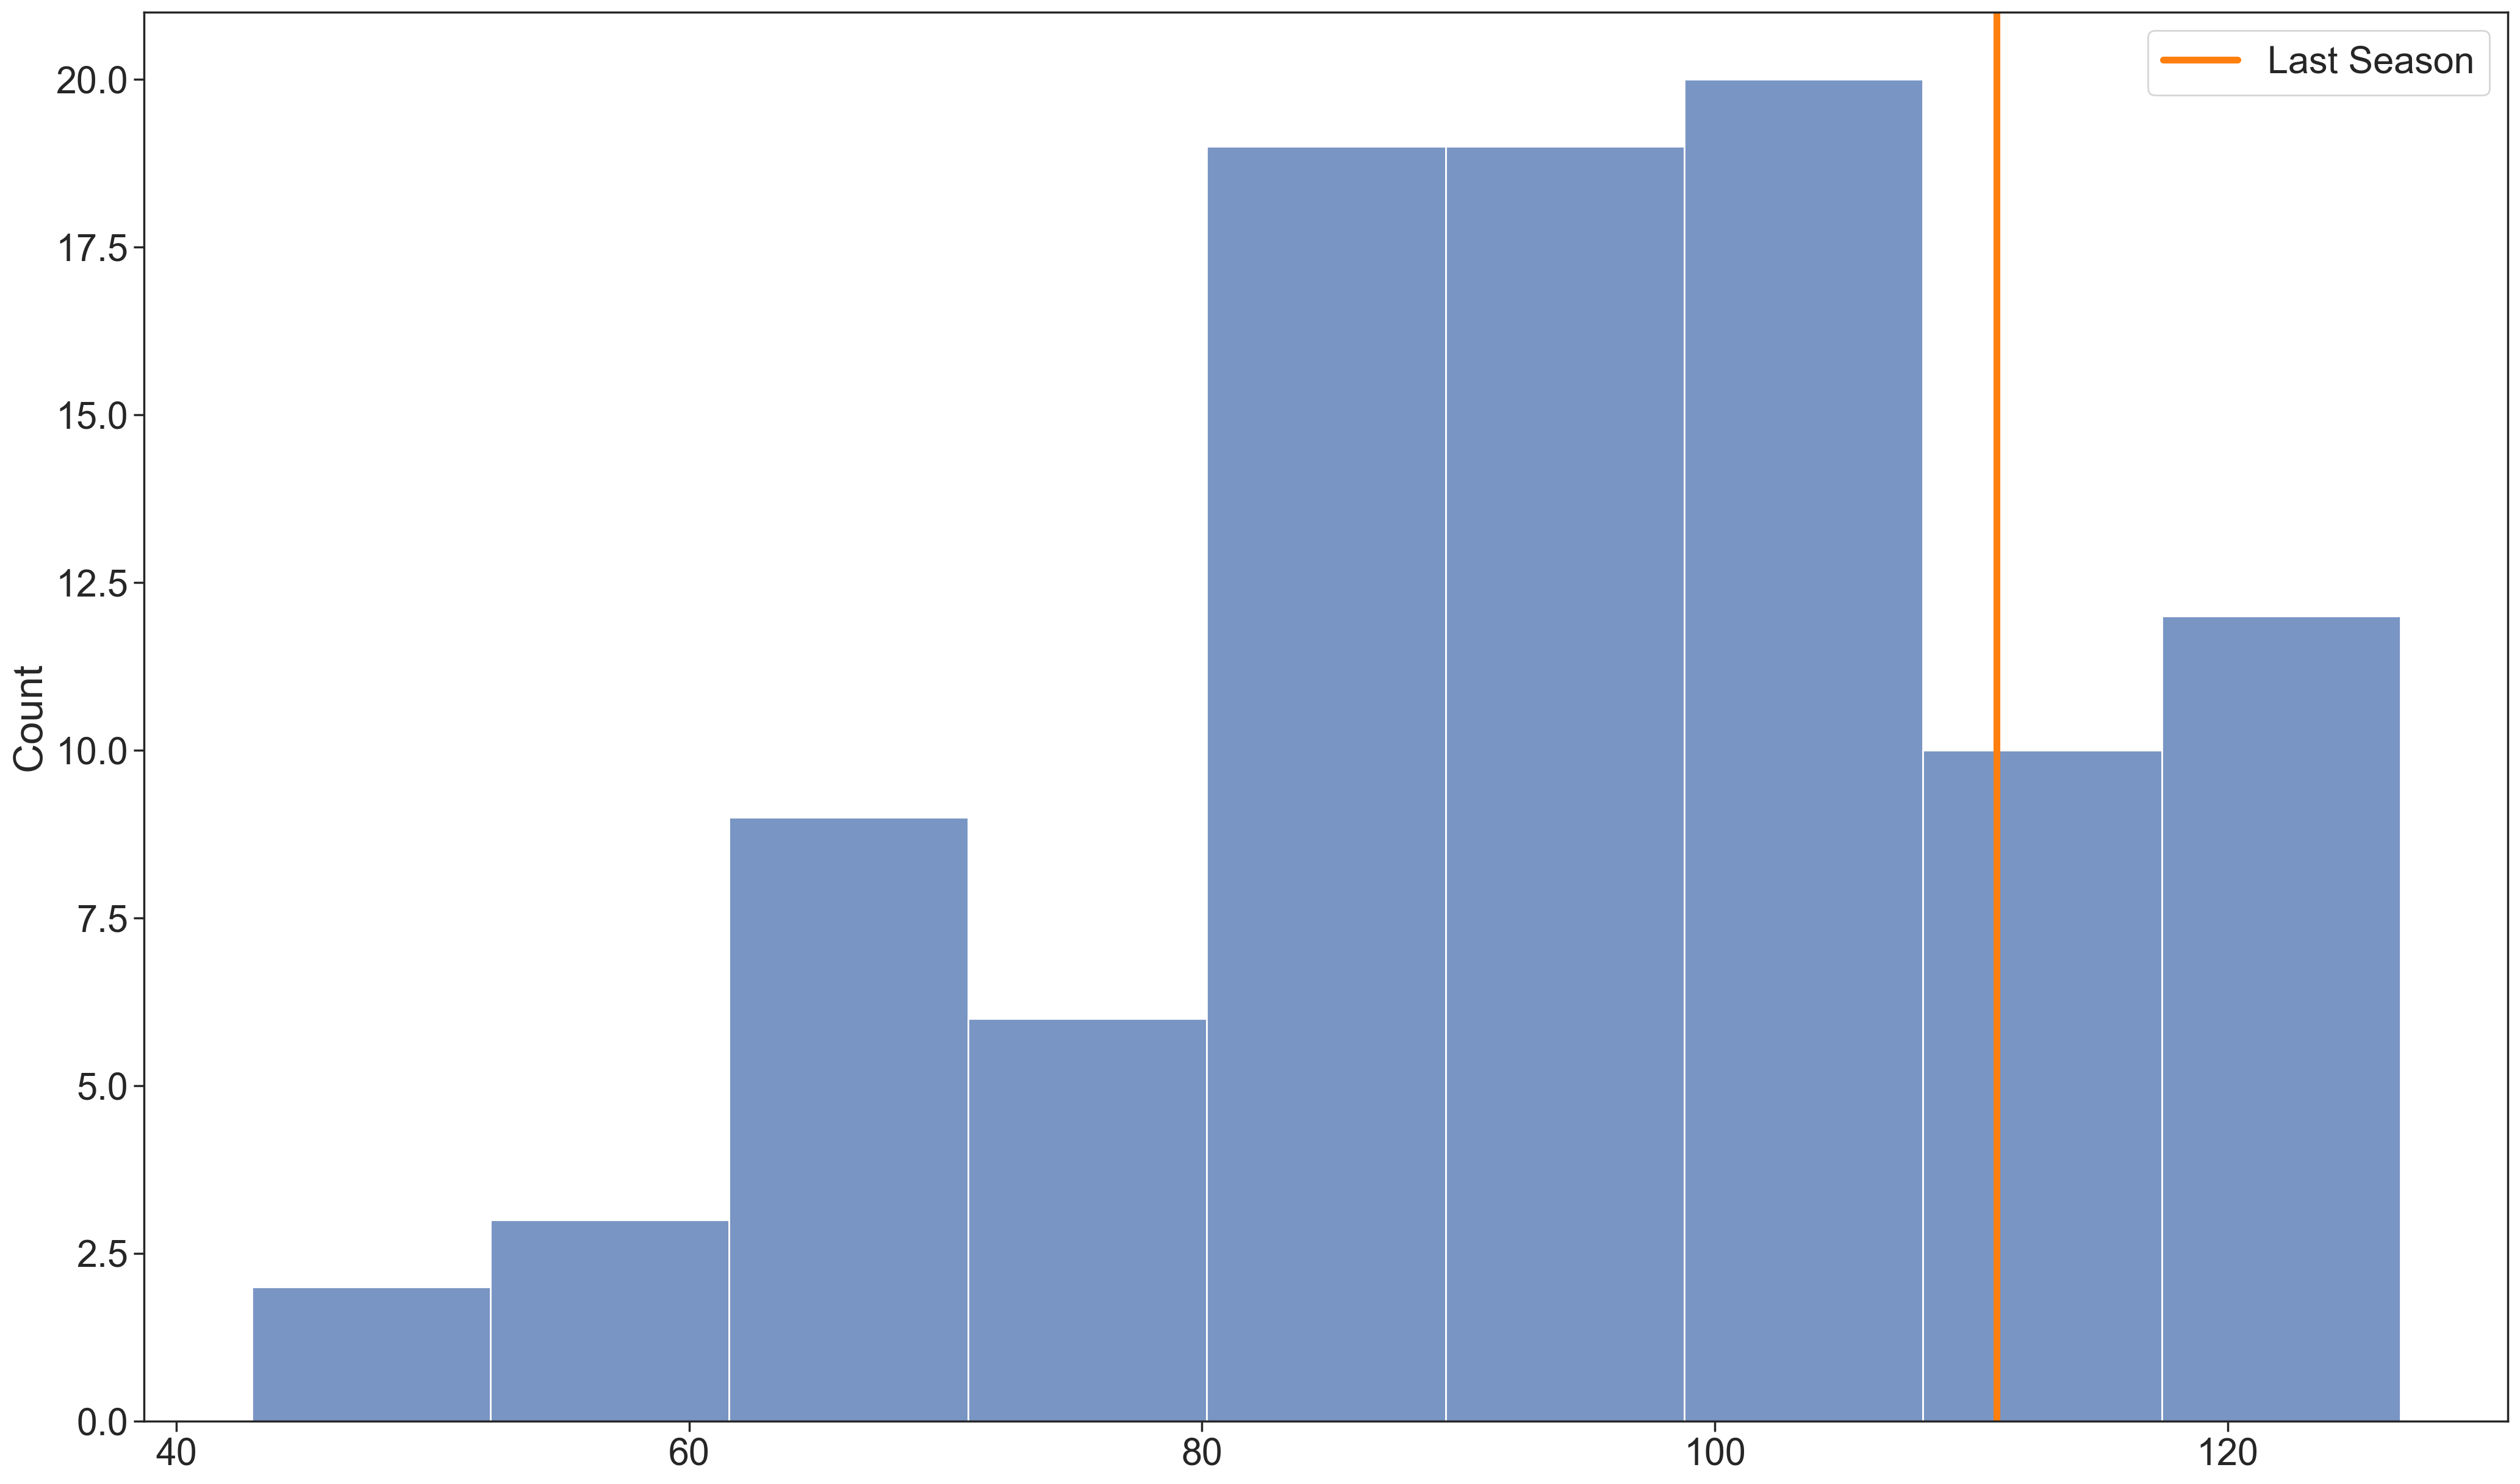

In [87]:
ax = sns.histplot(x=next_forecasts)
ax.axvline(vegas_df["total_points"][-1], linewidth=4, color="tab:orange", label="Last Season")
ax.legend()
plt.show()

In [89]:
interval = 1.96 * np.std(next_forecasts, ddof=1)
(np.mean(next_forecasts) - interval, np.mean(next_forecasts) + interval)

(58.20833507340709, 129.39624520550043)